In [37]:
import os
import random
import math
import h5py
import concurrent.futures
import matplotlib.pyplot as plt
font = {'size'   : 5}
plt.rc('font', **font)

import numpy as np
import pandas as pd
import pandas.api.types
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
from io import BytesIO

import torch
from torch import nn
import torch.nn.functional as F
import lightning as L

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold, StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


from libauc.losses import pAUCLoss
from libauc.optimizers import SOPAs
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score

import timm
import wandb

In [38]:
wandb.login()

True

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


In [40]:
default_config= {
 'VERSION': 'v4.0',
 'DESCRIPTION': 'change backbone for normal model',
 'DATA_PATH': 'isic-2024-challenge',
 
 #-------Global-------#
 'IMAGE_SIZE': 224,
 'SEED': 24,
 #################################################
 
 #-------Image Augmentation-------#

 #################################################

 #-------Training hyperparameter-------#
 'BACKBONE': "vgg16.tv_in1k", # [ "eca_nfnet_l0" 256,"tf_efficientnet_b0.in1k" 256; "tf_efficientnetv2_s.in21k" 300;  "seresnext26t_32x4d.bt_in1k" 224; "tf_efficientnet_b3.ns_jft_in1k" 300; "resnet34.a1_in1k" 224; "efficientnet_b3.ra2_in1k" 288; "resnet50.a1_in1k" 224; "eca_nfnet_l0.ra2_in1k" 224]
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 64,
 'LOSS': 'BCE With Logit'
 #################################################
}

In [41]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(default_config['SEED'])

In [42]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

# 1. Dataset

In [43]:
df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")

sgkf = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_data['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df_data, df_data.target, df_data.patient_id)):
    df_data.loc[val_idx, 'fold'] = fold
# df_data = df_data[df_data['iddx_1']!='Indeterminate'].reset_index(drop=True)

df_data.groupby(['fold', 'target']).size()

C:\Users\hoang\AppData\Local\Temp\ipykernel_6788\3672567262.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")


fold  target
0     0         80134
      1            77
1     0         80133
      1            83
2     0         80133
      1            78
3     0         80133
      1            78
4     0         80133
      1            77
dtype: int64

In [44]:
df_positive = df_data[df_data["target"] == 1].reset_index(drop=True)
df_negative = df_data[df_data["target"] == 0].sample(frac=0.02, random_state=default_config['SEED'])

df_data = pd.concat([df_positive, df_negative]).reset_index(drop=True)  # positive:negative = 1:20

df_data.groupby(['fold','target']).size()

fold  target
0     0         1615
      1           77
1     0         1614
      1           83
2     0         1582
      1           78
3     0         1577
      1           78
4     0         1625
      1           77
dtype: int64

In [45]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, df_data, mode='test'):
        self.df_data = df_data

        self.df_positive = df_data[df_data["target"] == 1].reset_index()
        self.df_negative = df_data[df_data["target"] == 0].reset_index()
        self.mode = mode

        if mode == 'train':
            ref_data = [{"isic_id":isic_id, "target":target} for isic_id, target in zip(df_data['isic_id'].tolist(), df_data['target'].tolist())]
            random.shuffle(ref_data)
            
            self.transform = albu.Compose([
                albu.Transpose(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.HorizontalFlip(p=0.5),
                albu.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.75),
                albu.OneOf([
                    albu.MotionBlur(blur_limit=5),
                    albu.MedianBlur(blur_limit=5),
                    albu.GaussianBlur(blur_limit=5),
                    albu.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
                albu.OneOf([
                    albu.OpticalDistortion(distort_limit=1.0),
                    albu.GridDistortion(num_steps=5, distort_limit=1.),
                    albu.ElasticTransform(alpha=3),
                ], p=0.7),
                albu.CLAHE(clip_limit=4.0, p=0.7),
                albu.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

                albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
                albu.MixUp(p=0, reference_data=ref_data, read_fn=self.read_fn),

                albu.CoarseDropout(max_height=int(default_config['IMAGE_SIZE'] * 0.0375), max_width=int(default_config['IMAGE_SIZE'] * 0.0375), p=0.7),
                
                albu.Normalize(
                        mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225], 
                        max_pixel_value=255.0, 
                        p=1.0
                    ),
                ToTensorV2(p=1.0)])
        else:
            self.transform = albu.Compose([
                albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
                albu.Normalize(
                        mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225], 
                        max_pixel_value=255.0, 
                        p=1.0
                    ),
                ToTensorV2(p=1.0)])
        
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.df_data)
    
    def read_fn(self, item):
        transform = albu.Compose([albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE'], p=1)], p=1)
        image = transform(image=np.array(Image.open(BytesIO(self.fp_hdf[item['isic_id']][()]))))['image']
        onehot_target = np.zeros(2, dtype=int)
        onehot_target[item['target']] = 1

        return {
            "image": image,
            "global_label": onehot_target
        }
    
    def __getitem__(self, index):
        if random.random() >=0.5:
            df = self.df_positive
        else:
            df = self.df_negative
        
        index = index % df.shape[0]
        sample_row = df.iloc[index]
        
        image = np.array(Image.open(BytesIO(self.fp_hdf[sample_row['isic_id']][()])))

        if self.mode=='train':
            onehot_target = np.zeros(2, dtype=int)
            onehot_target[sample_row['target']] = 1
            transformed = self.transform(image=image, global_label=onehot_target)
            image = transformed['image']
            y = np.argmax(transformed['global_label'])
        else:
            image = self.transform(image=image)['image']
            y = sample_row['target']
        
        return image, y

In [46]:
dataset = ISICDataset(hdf5_file=hdf5_file, df_data=df_data, mode='valid')
dataset[2151][1]

1

## 1.1 Display one batch in Dataset

C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


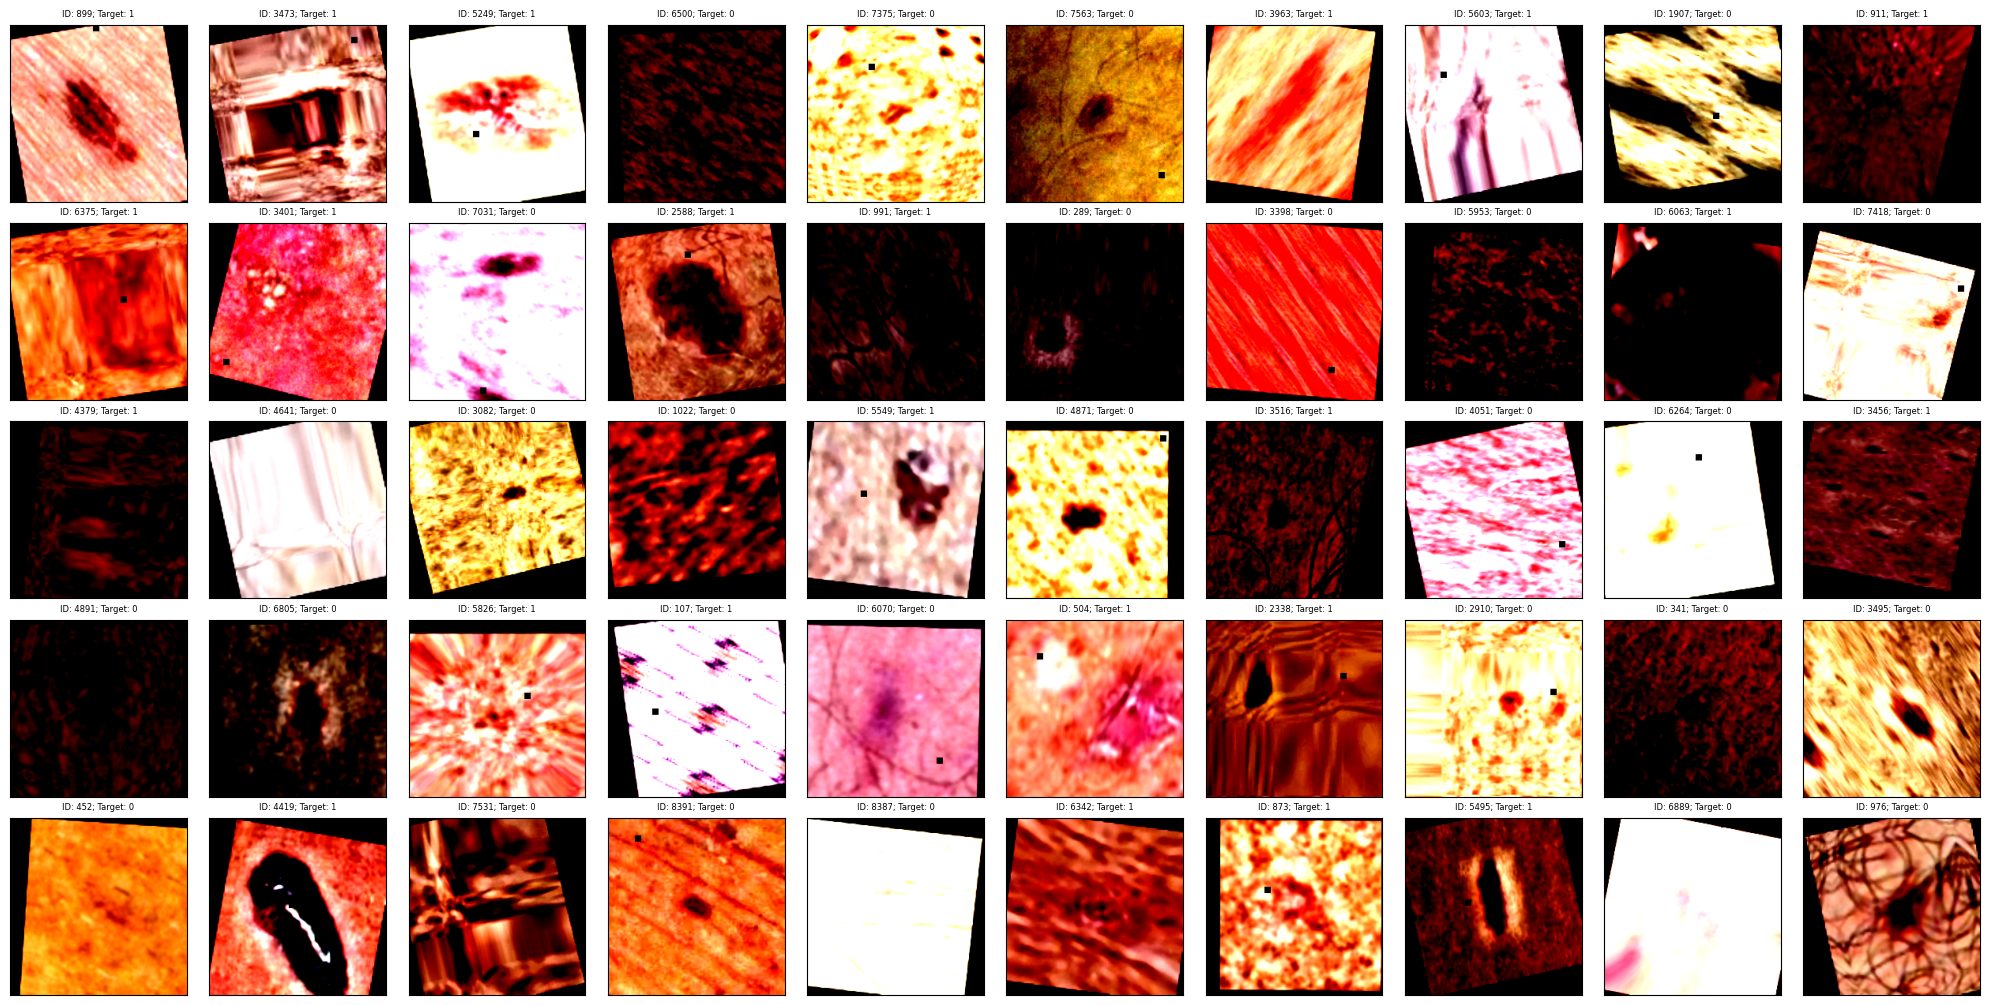

In [47]:
def display_batch(malignant_only=False):
    tmp_df = df_data
    if malignant_only:
        tmp_df = df_data[df_data['target']==1]
    dataset = ISICDataset(hdf5_file=hdf5_file, df_data=tmp_df, mode='train')
    fig = plt.figure(figsize=(20,10))
    
    img_index = np.random.randint(0, len(dataset)-1, 5*10)
    
    for i in range(len(img_index)):
        img, labels = dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy() 
        
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(np.transpose(img, (1,2,0)))
        lbl = labels.item()
        ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

    plt.tight_layout()
    plt.show()


display_batch(malignant_only=False)

## 2. Model

In [48]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class ISICModel(nn.Module):
    def __init__(self, num_classes):
        super(ISICModel, self).__init__()

        self.backbone = timm.create_model(default_config['BACKBONE'], pretrained=True, num_classes=num_classes)

        if ("efficient" in default_config['BACKBONE']) :
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        elif ("resnet34" in default_config['BACKBONE']):
            in_features = 512
            self.backbone.global_pool = nn.Identity()
            self.backbone.fc = nn.Identity()
        else:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head = nn.Identity()

        self.globalpooling = GeM()
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(in_features, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, ximage):
        x = self.backbone(ximage)
        if ("swin" in default_config['BACKBONE']):
            x = x.transpose(1,3).contiguous()
        x = self.globalpooling(x).flatten(1)
        x = self.dropout(x)
        x = self.linear(x)
        # x = self.sigmoid(x)
        return x

In [49]:
# model = ISICModel(num_classes=1).to(device)
# inputs = torch.randn(64, 3, 224, 224).to(device)

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     outputs = model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [50]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

# 3.Training loop

In [51]:
import gc
import warnings
from torch.cuda.amp import autocast, GradScaler
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [52]:
for f in range(default_config["FOLD"]):
    run = wandb.init(project="ISIC2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)
    wandb.alert(title=f"Start Model_Fold {f} !!!", text=f"Start Model_Fold {f} !!! [{default_config['DESCRIPTION']}]")
    # main loop of f-fold
    print('=================================================================================================')
    print(f"============================== Running training for fold {f} ==============================")
    
    train_df = df_data[df_data['fold'] != f].copy().reset_index(drop=True)
    valid_df = df_data[df_data['fold'] == f].copy().reset_index(drop=True)
    
    train_dataset = ISICDataset(hdf5_file, train_df, mode='train')
    valid_dataset = ISICDataset(hdf5_file, valid_df, mode='valid')

    print(f'Train Samples: {len(train_df)}')
#     display_batch(train_dataset)

    print(f'Valid Samples: {len(valid_df)}')
#     display_batch(valid_dataset)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

    model = ISICModel(num_classes=1).to(device)

    # criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()
    # loss_fn = pAUCLoss('1w', data_len=len(train_dataset), margin=0.6, gamma=0.1)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    # optimizer = SOPAs(model.parameters(), mode='adam', lr=1e-4, weight_decay=1e-6)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])

    # Training loop
    for epoch in range(default_config["EPOCHS"]):
        scaler = GradScaler()
        model.train()
        for idx,batch in enumerate(train_dataloader):
            inputs, targets = batch

            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            optimizer.zero_grad(set_to_none=False)
            # Forward pass

            with autocast():
                outputs = model(inputs).squeeze()
                # Compute loss
                loss = criterion(outputs, targets)

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
            wandb.log({"Learning Rate":  optimizer.param_groups[-1]['lr']}) #scheduler.get_last_lr()[0]

        model.eval()
        valid_step = []
        with torch.no_grad(), autocast():
            for idx, batch in enumerate(valid_dataloader):
                inputs, targets = batch
                inputs = inputs.to(device, dtype=torch.float)

                outputs = model(inputs).squeeze()
                valid_step.append({"logits": outputs, "targets": targets.to(torch.float)})

            output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
            target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

            val_loss = criterion(output_val, target_val)

            sigmoid = nn.Sigmoid()
            gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=['target'])
            pred_df = pd.DataFrame(sigmoid(output_val).numpy().astype(np.float32), columns=['target'])
            
            gt_df['isic_id'] = [f'id_{i}' for i in range(len(gt_df))]
            pred_df['isic_id'] = [f'id_{i}' for i in range(len(pred_df))]
            val_roc_auc = score(gt_df, pred_df, row_id_column_name='isic_id')
            # scheduler.step(val_roc_auc)

        print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f}, valid_score: {val_roc_auc:.4f} lr: {scheduler.get_last_lr()}")
        wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss, "Valid Score": val_roc_auc})
        gc.collect()

    torch.save(model.state_dict(), f"model/{default_config['VERSION']}/Model_Fold{f}.pt")
    wandb.save(f"model/{default_config['VERSION']}/Model_Fold{f}.pt")

    wandb.alert(title=f"Done Fold {f} !!!", text=f"Done Fold {f} !!!")
    run.finish()

============================== Running training for fold 0 ==============================
Train Samples: 6714
Valid Samples: 1692


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.5629, valid_loss: 0.4692, valid_score: 0.1244 lr: [4.7835904848296366e-05]
Epoch 2/10, train_loss: 0.3428, valid_loss: 0.4121, valid_score: 0.1415 lr: [0.00012967044569910625]
Epoch 3/10, train_loss: 0.3951, valid_loss: 0.3697, valid_score: 0.1430 lr: [0.00016999922355338866]
Epoch 4/10, train_loss: 0.4520, valid_loss: 0.3636, valid_score: 0.1430 lr: [0.00016142405320645356]
Epoch 5/10, train_loss: 0.3323, valid_loss: 0.3237, valid_score: 0.1545 lr: [0.00013771222918364657]
Epoch 6/10, train_loss: 0.4347, valid_loss: 0.2961, valid_score: 0.1632 lr: [0.00010356016903912207]
Epoch 7/10, train_loss: 0.3531, valid_loss: 0.2868, valid_score: 0.1610 lr: [6.573210713203398e-05]
Epoch 8/10, train_loss: 0.2768, valid_loss: 0.3009, valid_score: 0.1605 lr: [3.172035505381484e-05]
Epoch 9/10, train_loss: 0.1557, valid_loss: 0.2966, valid_score: 0.1598 lr: [8.26135743032128e-06]
Epoch 10/10, train_loss: 0.4217, valid_loss: 0.2911, valid_score: 0.1624 lr: [1.456446611341435

Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Training Loss,█▄▅▆▄▆▄▃▁▆
Valid Loss,█▆▄▄▂▁▁▂▁▁
Valid Score,▁▄▄▄▆███▇█
Learning Rate,0.0
Training Loss,0.42166
Valid Loss,0.29106
Valid Score,0.16241


============================== Running training for fold 1 ==============================
Train Samples: 6709
Valid Samples: 1697


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.5104, valid_loss: 0.5559, valid_score: 0.0906 lr: [4.7835904848296366e-05]
Epoch 2/10, train_loss: 0.4853, valid_loss: 0.5159, valid_score: 0.0945 lr: [0.00012967044569910625]
Epoch 3/10, train_loss: 0.3547, valid_loss: 0.4269, valid_score: 0.1358 lr: [0.00016999922355338866]
Epoch 4/10, train_loss: 0.4269, valid_loss: 0.4798, valid_score: 0.1365 lr: [0.00016142405320645356]
Epoch 5/10, train_loss: 0.4751, valid_loss: 0.4083, valid_score: 0.1268 lr: [0.00013771222918364657]
Epoch 6/10, train_loss: 0.3526, valid_loss: 0.4090, valid_score: 0.1306 lr: [0.00010356016903912207]
Epoch 7/10, train_loss: 0.3708, valid_loss: 0.4162, valid_score: 0.1302 lr: [6.573210713203398e-05]
Epoch 8/10, train_loss: 0.3511, valid_loss: 0.4114, valid_score: 0.1393 lr: [3.172035505381484e-05]
Epoch 9/10, train_loss: 0.4955, valid_loss: 0.4337, valid_score: 0.1367 lr: [8.26135743032128e-06]
Epoch 10/10, train_loss: 0.4343, valid_loss: 0.4275, valid_score: 0.1394 lr: [1.456446611341435

Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Training Loss,█▇▁▄▆▁▂▁▇▅
Valid Loss,█▆▂▄▁▁▁▁▂▂
Valid Score,▁▂▇█▆▇▇███
Learning Rate,0.0
Training Loss,0.43431
Valid Loss,0.42755
Valid Score,0.13939


============================== Running training for fold 2 ==============================
Train Samples: 6746
Valid Samples: 1660


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.4953, valid_loss: 0.4058, valid_score: 0.1410 lr: [4.783367019149212e-05]
Epoch 2/10, train_loss: 0.4739, valid_loss: 0.4286, valid_score: 0.1125 lr: [0.00012966600210459229]
Epoch 3/10, train_loss: 0.7220, valid_loss: 0.6999, valid_score: 0.0481 lr: [0.00016999923813419948]
Epoch 4/10, train_loss: 0.6453, valid_loss: 0.6268, valid_score: 0.0214 lr: [0.0001614255534540195]
Epoch 5/10, train_loss: 0.4745, valid_loss: 0.4257, valid_score: 0.1048 lr: [0.00013771491795553785]
Epoch 6/10, train_loss: 0.3345, valid_loss: 0.3519, valid_score: 0.1495 lr: [0.00010356351379109003]
Epoch 7/10, train_loss: 0.6560, valid_loss: 0.3793, valid_score: 0.1411 lr: [6.573544539493062e-05]
Epoch 8/10, train_loss: 0.4136, valid_loss: 0.3490, valid_score: 0.1439 lr: [3.172302564373246e-05]
Epoch 9/10, train_loss: 0.2865, valid_loss: 0.3301, valid_score: 0.1544 lr: [8.262831404173988e-06]
Epoch 10/10, train_loss: 0.2114, valid_loss: 0.3394, valid_score: 0.1508 lr: [1.4418658005344914

Learning Rate,▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Training Loss,▅▅█▇▅▃▇▄▂▁
Valid Loss,▂▃█▇▃▁▂▁▁▁
Valid Score,▇▆▂▁▅█▇▇██
Learning Rate,0.0
Training Loss,0.21139
Valid Loss,0.33939
Valid Score,0.15075


============================== Running training for fold 3 ==============================
Train Samples: 6751
Valid Samples: 1655


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.4391, valid_loss: 0.4679, valid_score: 0.1130 lr: [4.783367019149212e-05]
Epoch 2/10, train_loss: 0.5528, valid_loss: 0.5059, valid_score: 0.1245 lr: [0.00012966600210459229]
Epoch 3/10, train_loss: 0.4348, valid_loss: 0.5013, valid_score: 0.1121 lr: [0.00016999923813419948]
Epoch 4/10, train_loss: 0.6222, valid_loss: 0.4164, valid_score: 0.1365 lr: [0.0001614255534540195]
Epoch 5/10, train_loss: 0.4322, valid_loss: 0.4603, valid_score: 0.1242 lr: [0.00013771491795553785]
Epoch 6/10, train_loss: 0.3930, valid_loss: 0.4163, valid_score: 0.1368 lr: [0.00010356351379109003]
Epoch 7/10, train_loss: 0.2966, valid_loss: 0.3756, valid_score: 0.1407 lr: [6.573544539493062e-05]
Epoch 8/10, train_loss: 0.4905, valid_loss: 0.3846, valid_score: 0.1412 lr: [3.172302564373246e-05]
Epoch 9/10, train_loss: 0.2485, valid_loss: 0.3853, valid_score: 0.1428 lr: [8.262831404173988e-06]
Epoch 10/10, train_loss: 0.4811, valid_loss: 0.3453, valid_score: 0.1516 lr: [1.4418658005344914

Learning Rate,▁▁▂▃▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Training Loss,▅▇▄█▄▄▂▆▁▅
Valid Loss,▆██▄▆▄▂▃▃▁
Valid Score,▁▃▁▅▃▅▆▆▆█
Learning Rate,0.0
Training Loss,0.4811
Valid Loss,0.34529
Valid Score,0.15165


============================== Running training for fold 4 ==============================
Train Samples: 6704
Valid Samples: 1702


C:\Users\hoang\AppData\Roaming\Python\Python39\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


Epoch 1/10, train_loss: 0.5281, valid_loss: 0.4703, valid_score: 0.1241 lr: [4.7835904848296366e-05]
Epoch 2/10, train_loss: 0.5496, valid_loss: 0.3961, valid_score: 0.1271 lr: [0.00012967044569910625]
Epoch 3/10, train_loss: 0.4212, valid_loss: 0.3939, valid_score: 0.1346 lr: [0.00016999922355338866]
Epoch 4/10, train_loss: 0.3445, valid_loss: 0.5069, valid_score: 0.1238 lr: [0.00016142405320645356]
Epoch 5/10, train_loss: 0.5206, valid_loss: 0.4080, valid_score: 0.1358 lr: [0.00013771222918364657]
Epoch 6/10, train_loss: 0.4803, valid_loss: 0.4107, valid_score: 0.1389 lr: [0.00010356016903912207]
Epoch 7/10, train_loss: 0.4268, valid_loss: 0.4167, valid_score: 0.1390 lr: [6.573210713203398e-05]
Epoch 8/10, train_loss: 0.3674, valid_loss: 0.3684, valid_score: 0.1404 lr: [3.172035505381484e-05]
Epoch 9/10, train_loss: 0.1825, valid_loss: 0.4039, valid_score: 0.1405 lr: [8.26135743032128e-06]
Epoch 10/10, train_loss: 0.3405, valid_loss: 0.4192, valid_score: 0.1301 lr: [1.456446611341435

Learning Rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
Training Loss,██▆▄▇▇▆▅▁▄
Valid Loss,▆▂▂█▃▃▃▁▃▄
Valid Score,▁▂▆▁▆▇▇██▄
Learning Rate,0.0
Training Loss,0.34046
Valid Loss,0.41924
Valid Score,0.13014


# Evaluation

In [53]:
class ISICTestDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_file, isic_ids, transform):
        self.isic_ids = isic_ids

        self.transform = transform
        self.fp_hdf = hdf5_file
    
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        image = self.transform(image=image)['image']
        
        return image
    
test_transform = albu.Compose([
        albu.Resize(height=default_config['IMAGE_SIZE'], width=default_config['IMAGE_SIZE']),
        albu.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(p=1.0)])

In [54]:
df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
hdf5_file = h5py.File(f"{default_config['DATA_PATH']}/train-image.hdf5", mode="r")
df_metadata['age_approx'] = df_metadata['age_approx'].fillna(df_metadata['age_approx'].mean())

sgkf = StratifiedGroupKFold(n_splits=default_config["FOLD"])
df_metadata['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df_metadata, df_metadata.target, df_metadata.patient_id)):
    df_metadata.loc[val_idx, 'fold'] = fold

model = ISICModel(1)
oof_predictions = np.zeros(len(df_metadata))

for f in range(default_config['FOLD']):
    model.load_state_dict(torch.load(f"model/{default_config['VERSION']}/Model_Fold{f}.pt"))
    model.to(device)
    model.eval()
    
    fold_df = df_metadata[df_metadata['fold'] == f].copy()
    test_dataset = ISICTestDataset(hdf5_file, fold_df['isic_id'].values, test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=default_config['BACTHSIZE'], shuffle=False)
    
    all_preds = []
    models = [model]
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        
        for imgs in tqdm(test_loader):
            imgs = imgs.to("cuda")
            preds = [sigmoid(model(imgs).detach().cpu()).numpy() for model in models]
            preds = np.mean(preds, 0)
            all_preds.extend(preds)
    all_preds=np.array(all_preds).flatten()
    
    oof_predictions[fold_df.index] = all_preds

oof_df = pd.DataFrame({
        'isic_id': df_metadata['isic_id'],
        'target': df_metadata['target'],
        'fold': df_metadata['fold'],
        'oof_prediction': oof_predictions
    })

oof_df.to_csv(f'train_oof_prediction_{default_config["VERSION"].replace(".","_")}.csv', index=False)

C:\Users\hoang\AppData\Local\Temp\ipykernel_6788\1337986289.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv(f"{default_config['DATA_PATH']}/train-metadata.csv")
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vgg16.tv_in1k)
INFO:timm.models._hub:[timm/vgg16.tv_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
100%|█████████▉| 1253/1254 [09:16<00:00,  5.25it/s]c:\Users\hoang\.conda\envs\bird\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_wo